# Check observing window calculation

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
from astropy.coordinates import AltAz, Angle, EarthLocation, get_sun, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import seaborn as sns
import sqlite3

import constraints as c
from db import DBConnectorSQLite, SQLiteConnection
from fieldgrid import FieldGrid, FieldGridIsoLat
from surveyplanner import Field, ObsWindow, Telescope, SurveyPlanner, Prioritizer

Create telescope:

In [5]:
db = DBConnectorSQLite('test_planner_temp.sqlite3')

In [254]:
telescope = db.get_observatory('Skinakas')
telescope = Telescope(
        telescope['lat'], telescope['lon'], telescope['height'], telescope['utc_offset'], name=telescope['name'])
print(telescope)

Telescope Skinakas created.
Telescope 
Name: Skinakas
Lat:     +35.2119 deg
Lon:      24.8992 deg
Height:   1750.00 m
UTC offset:  2.00 hours



Read constraints from database:

In [255]:
constraints = db.get_constraints('Skinakas')
print(constraints)

{'Twilight': {'twilight': -12.0}, 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'}, 'HourangleLimit': {'limit': 5.33, 'limit_lo': -5.33}, 'MoonDistance': {'limit': 10.0}}


Read the twilight definition (i.e. Sun declination at which the night 'starts') from the `constraints`-dictionary:

In [256]:
twilight = constraints['Twilight']['twilight']
print(twilight)

-12.0


Remove the `'Twilight'` entry from the dictionary. All remaining entries are telescope specific observational constraints:

In [257]:
del constraints['Twilight']

(1) Parse the constraints names, parameter names, and parameter values into executable code, (2) create the corresponding constraint class instances, and (3) add them to the `telescope`-instance:

In [258]:
for constraint_name, params in constraints.items():
    
    # parse constraint code:
    text = f"c.{constraint_name}("
    
    for arg, val in params.items():
        if isinstance(val, str):
            text += f"{arg}='{val}', "
        else:
            text += f"{arg}={val}, "
    
    if text[-1] == "(":
        text += ")"
    else:
        text = f"{text[:-2]})"
    
    print(text)
    
    # evaluate code and add constraint to telescope:
    constraint = eval(text)
    telescope.add_constraint(constraint)

c.AirmassLimit(limit=2.0, conversion='secz')
Constraint added: Airmass limit: 2.00
c.HourangleLimit(limit=5.33, limit_lo=-5.33)
Constraint added: Hourangle limit:
Lower limit: -5.33 hourangle
Upper limit: 5.33 hourangle
c.MoonDistance(limit=10.0)
Constraint added: Moon distance: 10.00 deg


Get a field:

In [312]:
field_id = 359 # rising field
#field_id = 478 # setting field
field = db.get_field_by_id(field_id)[0]
field = surveyplanner._tuple_to_field(field)

Create `SurveyPlanner` instance. The database is irrelevant, we just need one method of the class:

In [313]:
surveyplanner = SurveyPlanner('test_planner_temp.sqlite3')

Run calculation for one month:

In [366]:
# config test:
time_interval_init = 5. * u.min
#time_interval_refine = 0 * u.min
#time_interval_refine = 1 * u.min
time_interval_refine = 0.1 * u.min

#------------------------------
day = []
time_sunset = []
time_sunrise = []
obswindow_start = []
obswindow_stop = []
obswindow_duration = []

for d in range(1, 32):
    t_sunset, t_sunrise = telescope.get_sun_set_rise(2024, 1, d, twilight)
    day.append(d)
    time_sunset.append(np.mod(t_sunset.mjd, 1))
    time_sunrise.append(np.mod(t_sunrise.mjd, 1))
    
    frame = telescope.get_frame(t_sunset, t_sunrise, time_interval_init)
    
    obsw_start, obsw_stop = field.get_obs_window(telescope, frame, t_sunrise, refine=time_interval_refine)[0]
    obswindow_start.append(np.mod(obsw_start.mjd, 1))
    obswindow_stop.append(np.mod(obsw_stop.mjd, 1))
    obswindow_duration.append(obsw_stop.mjd - obsw_start.mjd)

In [367]:
data = DataFrame({
        'day': day, 'time_sunset': time_sunset, 'time_sunrise': time_sunrise, 'obswindow_start': obswindow_start,
        'obswindow_stop': obswindow_stop, 'obswindow_duration': obswindow_duration})
data['obswindow_duration_diff'] = np.r_[0, np.diff(data['obswindow_duration'])] * 24 * 3600
data

,day,time_sunset,time_sunrise,obswindow_start,obswindow_stop,obswindow_duration,obswindow_duration_diff
0,1,0.679499,0.186976,0.020749,0.186929,0.166181,0.000000
1,2,0.679994,0.187121,0.018050,0.187078,0.169028,246.000000
2,3,0.680501,0.187248,0.015293,0.187237,0.171944,252.000000
3,4,0.681019,0.187355,0.012547,0.187339,0.174792,246.000000
4,5,0.681548,0.187443,0.009812,0.187381,0.177569,240.000000
5,6,0.682087,0.187512,0.007087,0.187504,0.180417,246.000000
6,7,0.682635,0.187561,0.004371,0.187496,0.183125,234.000001
7,8,0.683193,0.187590,0.001665,0.187568,0.185903,240.000000
8,9,0.683758,0.187600,0.998897,0.187577,0.188681,240.000000
9,10,0.684330,0.187589,0.996205,0.187524,0.191319,228.000000


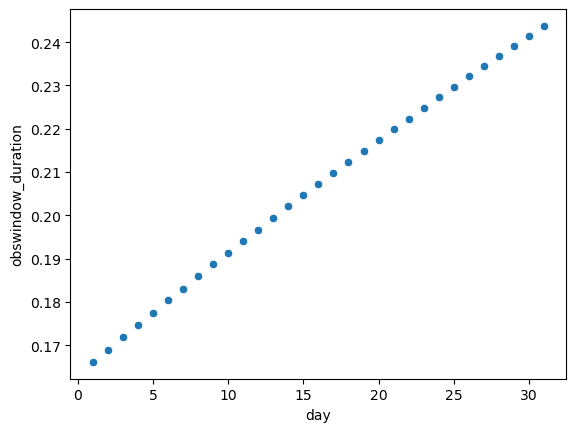

In [368]:
sns.scatterplot(data=data, x='day', y='obswindow_duration');

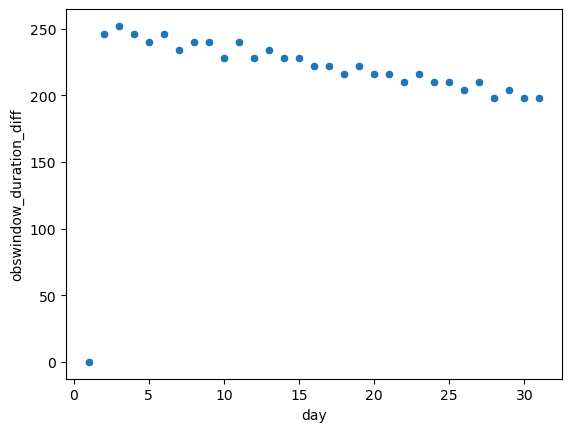

In [369]:
sns.scatterplot(data=data, x='day', y='obswindow_duration_diff');

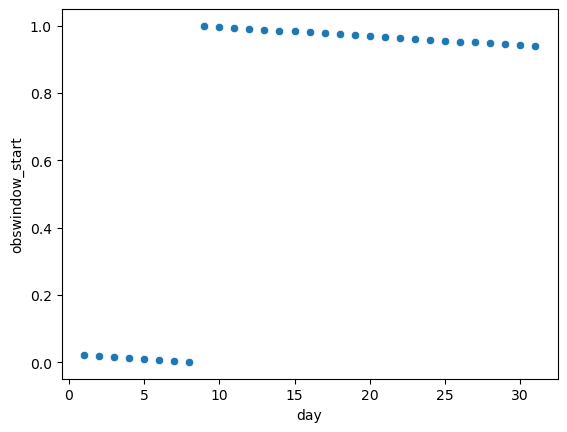

In [370]:
sns.scatterplot(data=data, x='day', y='obswindow_start');

<AxesSubplot:xlabel='day'>

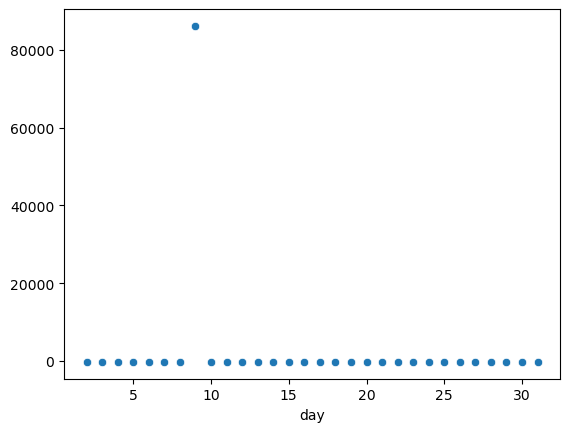

In [371]:
sns.scatterplot(x=data.iloc[1:]['day'], y=np.diff(data['obswindow_start'])*24*3600)

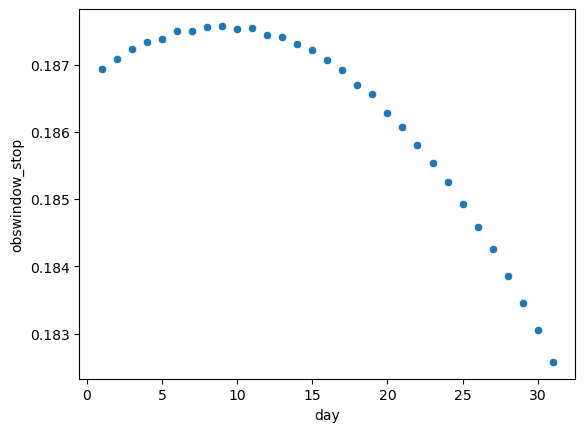

In [372]:
sns.scatterplot(data=data, x='day', y='obswindow_stop');

<AxesSubplot:xlabel='day'>

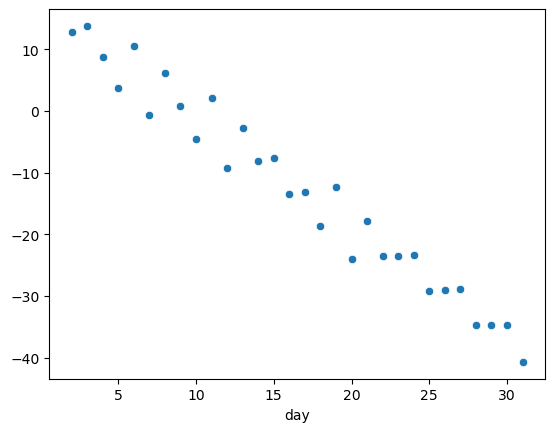

In [373]:
sns.scatterplot(x=data.iloc[1:]['day'], y=np.diff(data['obswindow_stop'])*24*3600)

<AxesSubplot:xlabel='day', ylabel='time_sunset'>

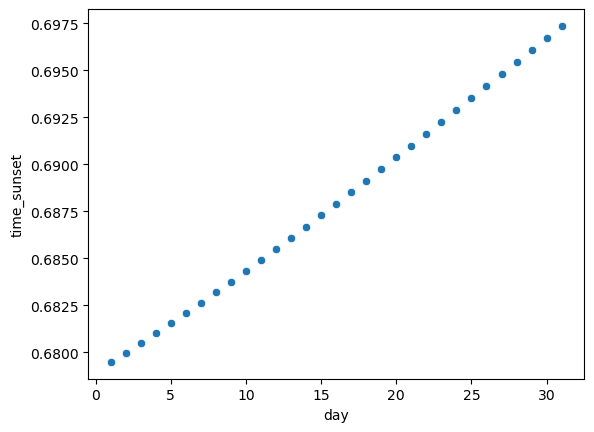

In [374]:
sns.scatterplot(data=data, x='day', y='time_sunset')

<AxesSubplot:xlabel='day', ylabel='time_sunrise'>

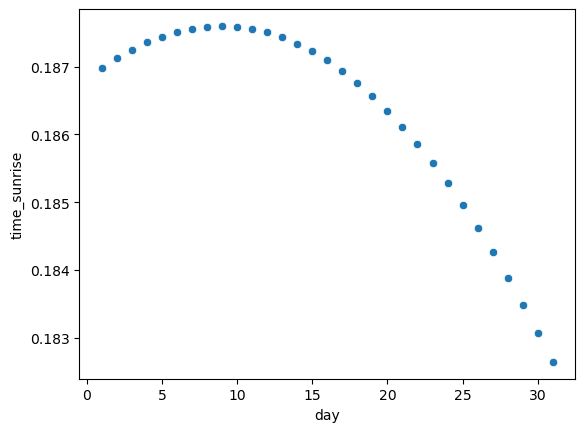

In [375]:
sns.scatterplot(data=data, x='day', y='time_sunrise')

**Results:**

- Without refinement the observing window durations can jump from one day to the next. The reason is the coarse time sampling.
- With refinement we can remove/reduce these jumps.
- It is important to find a good compromise between accuracy and calculation time. The latter increases with a fine refinement time grid.
- The test results look good with an intial time interval of 5 minutes and a refinement interval of 0.1 minutes.